In [29]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
!bash pose/getModels.sh

--2021-11-14 11:19:23--  https://www.dropbox.com/s/2h2bv29a130sgrk/pose_iter_440000.caffemodel
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2h2bv29a130sgrk/pose_iter_440000.caffemodel [following]
--2021-11-14 11:19:23--  https://www.dropbox.com/s/raw/2h2bv29a130sgrk/pose_iter_440000.caffemodel
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce59669f2631cc6e052f5bdf216.dl.dropboxusercontent.com/cd/0/inline/BZ8ZXfwDTxPS_4lPf3An_-bgq3ABb8Ecc1wW-vj8KfYef8ARn_OuZFz5FmIlry2Dr4GdkMHhpAwFd68qVtSRdLOILqi_p18J6JIMvgueQrHSY6fBlRmbQRmblUsfC1fXJB7iDeQ8n9xpNgBotu2f2wAi/file# [following]
--2021-11-14 11:19:23--  https://uce59669f2631cc6e052f5bdf216.dl.dropboxusercontent.com/cd/0/inline/BZ8ZXfwDTxPS_4lPf3An_-bgq3ABb8Ecc1wW-vj8KfYef

In [20]:
ls

pose/  sample_data/


## Specify the model to be used
COCO and MPI are body pose estimation model. COCO has 18 points and MPI has 15 points as output.

HAND is hand keypoints estimation model. It has 22 points as output

Ensure that the model files are available in the folders.

In [31]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

#### We find the keypoints for a image with only single person

In [32]:
frame = cv2.imread("pose/person.png")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

#### Pass it through the network

In [33]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

#### gather the points and plot the keypoints and the skeleton figure

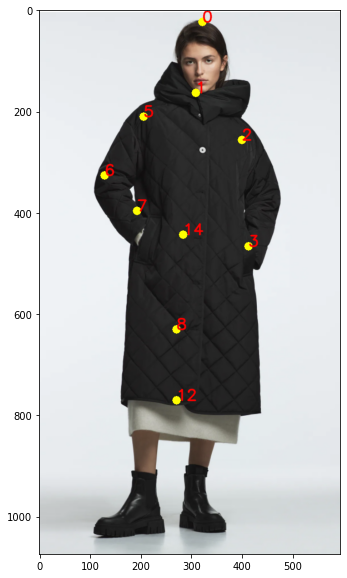

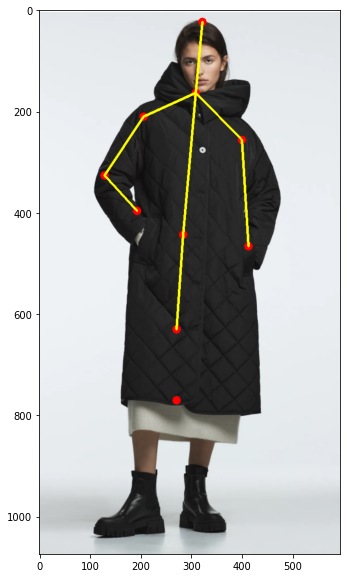

In [34]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))